- title: "Kaggle: facial keypoints detection"
- description: "Facial keypoints detection with PyTorch"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Introduction

## Overview (from [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/overview))


The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

- tracking faces in images and video
- analysing facial expressions
- detecting dysmorphic facial signs for medical diagnosis
- biometrics / face recognition

Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

This getting-started competition provides a benchmark data set and an R tutorial to get you going on analysing face images. Get started with R >>

Acknowledgements
The data set for this competition was graciously provided by Dr. Yoshua Bengio of the University of Montreal. James Petterson.

# Dataset description (from Kaggle)

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files

- training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
- test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels
- submissionFileFormat.csv: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict. 

# Strategy and to do

1. 
- import data, check, clean
- visu data

2. 
- create base model by averageing keypoints position
- create a submission file and get a score for the base model

3. 
- import pretrained model
- pass images through
- finetune the last layers to predict keypoint positions

# Imports

In [1]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, models, transforms
from PIL import Image

# Data overview

In [2]:
# Import keypoints
keypoints_df = pd.read_csv("data/training.csv",
                            usecols=range(30))

# Import images
images_df = pd.read_csv("data/training.csv",
                         usecols = [30])
# convert images to numpy array, reshape and rescale
images_df['Image'] = images_df['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape(96,96)/255.0)

In [3]:
keypoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [4]:
images_df.head()

,Image
0,"[[0.9333333333333333, 0.9254901960784314, 0.92..."
1,"[[0.8588235294117647, 0.8431372549019608, 0.8,..."
2,"[[0.5647058823529412, 0.5568627450980392, 0.62..."
3,"[[0.7568627450980392, 0.7529411764705882, 0.75..."
4,"[[0.5764705882352941, 0.5803921568627451, 0.62..."


In [5]:
keypoints_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [6]:
keypoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

There are 7049 rows in the dataset. Each row describes the keypoints related to an image. Most samples have data for the center of the left and right eye and the center of the bottom lip. Other features are available on only ~30% of the samples. My strategy is not to infer the missing values, but rather to omit them in the calculation of the loss function.

# Visualizing the data

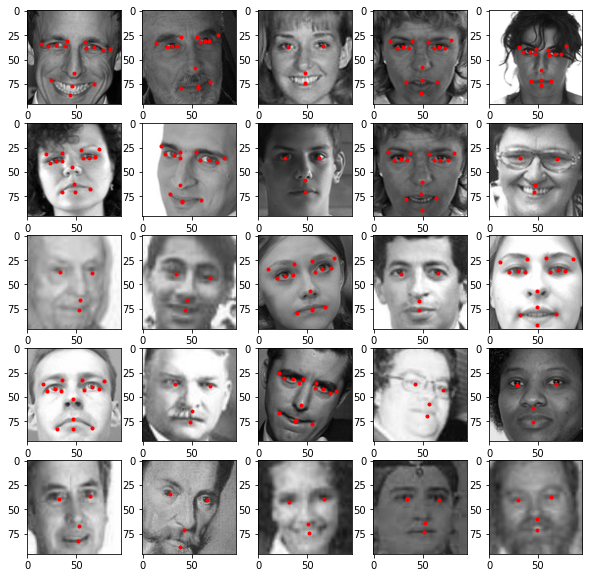

In [7]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=[10,10])

# Random samples
I = (np.random.rand(nrows*ncols) * keypoints_df.shape[0]).astype(int) 

i = 0
for ir in range(nrows):
    for ic in range(ncols):
        plt.sca(ax[ir,ic])
        plt.imshow(images_df.loc[I[i],'Image'], cmap='gray', vmin=0, vmax=1.0)
        plt.plot(keypoints_df.iloc[I[i],0::2],
                 keypoints_df.iloc[I[i],1::2],
                 '.r')
        i+=1

# Baseline model

Before, we go on to apply advanced machine learning techniques, it is useful to create a simple baseline model. The baseline is used to assess how much better the final model is performing compared to a simple solution. Here, I'll use the mean position of each keypoint as my baseline model. 

In [8]:
baseline_df = keypoints_df.mean()

The baseline model root mean squared error (RMSE) is:

In [9]:
RMSE_baseline = ((keypoints_df-baseline_df)**2).sum().sum()
print(f"RMSE baseline: {RMSE_baseline: .2e}")

RMSE baseline:  1.59e+06


Let's visualize how the baseline model compares to the data

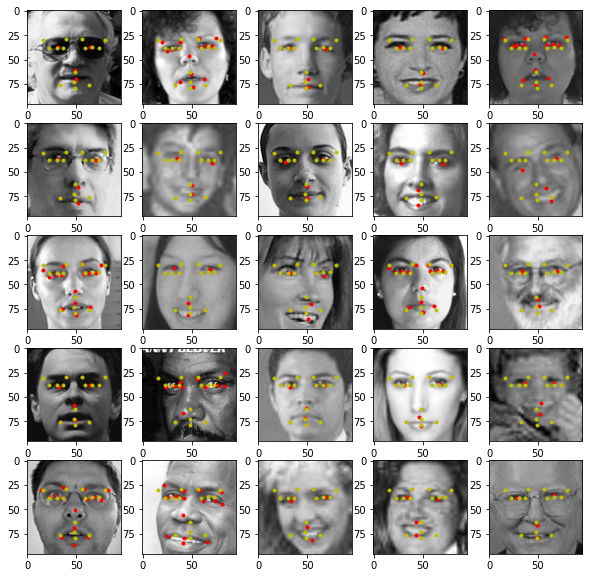

In [10]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=[10,10])

# Random samples
I = (np.random.rand(nrows*ncols) * keypoints_df.shape[0]).astype(int) 

i = 0
for ir in range(nrows):
    for ic in range(ncols):
        plt.sca(ax[ir,ic])
        plt.imshow(images_df.loc[I[i],'Image'], cmap='gray', vmin=0, vmax=1.0)
        plt.plot(keypoints_df.iloc[I[i],0::2],
                 keypoints_df.iloc[I[i],1::2],
                 '.r')
        plt.plot(baseline_df.iloc[0::2],
                 baseline_df.iloc[1::2],
                 '.y')
        i+=1

As we can see from the above figure, all the participants look straight into the camera, and their face is relatively well centered and with a similar scale. Thus, the baseline already gives meaningful prediction for every picture. Let's try to beat that.

# Neural network

My strategy is to pass the images through a pretrained neural network train on a classification task with the ImageNet dataset. 

## Import a pretrained model

In [11]:
model = torchvision.models.resnet18(pretrained=True)#.features.to(device).eval()
display(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

First, I freeze the parameters because I don't need to retrain the whole model.

In [12]:
for p in model.parameters():
    p.requires_grad_(False)

The last layer is a fully connected layer used for classification. Let's replace it with another fully connected layer aimed at predicting the position of our keypoints.

In [13]:
model.fc = nn.Linear(in_features=512, out_features=keypoints_df.shape[1])

A little sanity check: all layers should have `requires_grad==False` except the last two layers (i.e., the fully convolutional and output layers).

In [14]:
# for p in model.parameters():
#     print(p.shape, p.requires_grad)

torch.Size([64, 3, 7, 7]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([128, 64, 3, 3]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 64, 1, 1]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([256, 128, 3, 3]) False
torch.Size([256]) False
torch.Size([256]) False
torch.Size([256, 256, 3, 3]) False
torch.Size([256]) False
torch.Size([256]) False
torch.Size([256, 128, 1, 1]

# Prepare a dataloader

In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
input_size = [96,96]

data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
data_transforms_train = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),


# print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets


# train_image = datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_train)
# test_image = datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_train)
# image_datasets = {x:  for x in ['train', 'val']}
# # Create training and validation dataloaders
# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# # Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_dataframe, label_dataframe):
        self.img_df = image_dataframe
        self.label_df = label_dataframe

    def __len__(self):
        return self.img_df.shape[0]

    def __getitem__(self, index):
        T = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        img = torch.from_numpy(self.img_df.iloc[index].item()).reshape(1,96,96)
        label = torch.from_numpy(np.array(self.label_df.iloc[index]))#.astype(torch.float64)
        
        return (
            (torch.cat([img,img,img],dim=0)).float(), # making a RGB image out of a gray one
            label.float()
        )

dataset = MyDataset(images_df, keypoints_df)

In [17]:
batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train

In [18]:
def train(model, dataloader, optimizer, n_epoch, loss_fn, device):
    for i_epoch in range(n_epoch):
        print(f"Epoch {i_epoch:03d} ======")
        n_batch = len(dataloader)
        n_out = int(len(dataloader)/10)
        for i_batch, (img, label) in enumerate(dataloader):
            img = img.to(device)
            label = label.to(device)
            out = model(img)
            optimizer.zero_grad()
            I = torch.isnan(label)
            label[I] = 0.0
            out[I] = 0.0
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            if i_batch%n_out==0:
                with torch.no_grad():
                    print(f"batch {i_batch}/{n_batch}, loss: {loss.item()/img.shape[0]}")

In [38]:
# Setup training
device = 'cpu'
model.fc = nn.Linear(in_features=512, out_features=keypoints_df.shape[1]) # reinitialize the model
model.layer4[1].conv2.requires_grad_(True) # Also finetune the last convolution
optimizer = torch.optim.Adam(model.parameters(),lr=1.0)
n_epoch = 1
loss_fn = torch.nn.MSELoss()

train(model, dataloader, optimizer, n_epoch, loss_fn, device)

Epoch 000 ======
batch 0/111, loss: 17.319019317626953
batch 11/111, loss: 177.7447967529297
batch 22/111, loss: 19.560243606567383
batch 33/111, loss: 11.168707847595215
batch 44/111, loss: 3.440882444381714
batch 55/111, loss: 2.4006714820861816
batch 66/111, loss: 1.0105470418930054
batch 77/111, loss: 0.6900650858879089
batch 88/111, loss: 0.4862620532512665
batch 99/111, loss: 0.30269959568977356
batch 110/111, loss: 2.577732721964518


# Visualize results

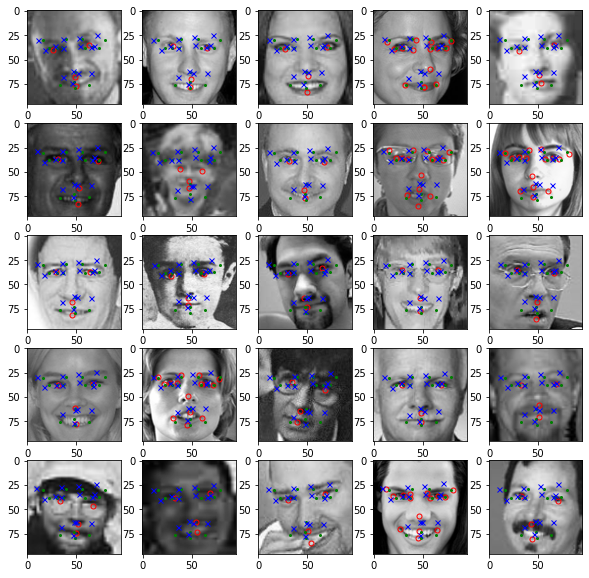

In [39]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows,ncols, figsize=[10,10])

# Random samples
I = (np.random.rand(nrows*ncols) * keypoints_df.shape[0]).astype(int) 

i = 0
for ir in range(nrows):
    for ic in range(ncols):
        plt.sca(ax[ir,ic])
        plt.imshow(images_df.loc[I[i],'Image'], cmap='gray', vmin=0, vmax=1.0)
        plt.plot(keypoints_df.iloc[I[i],0::2],
                 keypoints_df.iloc[I[i],1::2],
                 'or',markersize=5.0,markerfacecolor='none')
        plt.plot(baseline_df.iloc[0::2],
                 baseline_df.iloc[1::2],
                 'og',markersize=2.0)
        
        with torch.no_grad():
            img, kp = dataset.__getitem__(I[i])            
            kp_predict = model(img.reshape(1,3,96,96))[0]
#             print(kp_predict)
            plt.plot(kp_predict[0::2],
                     kp_predict[1::2],
                     'xb',markersize=5.0)
        i+=1

Note: It looks like I'm not really making a better prediction than the baseline. Maybe I need to train longer. But also, I should take care of the missing values now. Actually I was using only a really small subset of the dataset (200/7000 samples). Also, use data augmentation

In [21]:
A = np.array([1.0, 0.0 ,np.nan, np.nan, 0.0])

In [22]:
A

array([ 1.,  0., nan, nan,  0.])

In [23]:
np.argwhere(np.isnan(A))

array([[2],
       [3]])

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)